In [5]:
import pandas as pd
import numpy as np

from top2vec import Top2Vec

import re
import emoji
import contractions


from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from hdbscan import HDBSCAN

# Visualization Libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import umap
import plotly.graph_objects as go
from scipy.cluster.hierarchy import dendrogram, linkage

import plotly.figure_factory as ff
from umap import UMAP
import math


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\justy\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\justy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**IMPORT FILE**

In [6]:
df = pd.read_csv("E:\JUSTYN\JUSTYN\BERTOPIC\medical_data.csv")
df

C:\Users\justy\AppData\Local\Temp\ipykernel_4704\3355607802.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("E:\JUSTYN\JUSTYN\BERTOPIC\medical_data.csv")


,user_id,username,time,rating,original_text,translated_text,final_with_stopword,final_no_stopword,ori_wc,final_wc,...,category_12,category_13,category_14,category_15,category_16,category_17,category_18,category_19,category_20,category_21
0,1.144028e+20,Sajida Dar,1583977664092,5.0,"Great people,great staff and great facility to...","Great people,great staff and great facility to...",great people great staff and great facility to...,great people great staff great facility go thu...,9,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.027817e+20,Tamara Walker,1604380776309,2.0,Security guard asked me to put a mask on my 13...,Security guard asked me to put a mask on my 13...,security guard ask me to put a mask on my 13 m...,security guard ask put mask 13 month old baby ...,65,68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.147746e+20,Christina Veres,1560489213707,4.0,One of the better Cub foods that I have shoppe...,One of the better Cub foods that I have shoppe...,one of the good cub food that i have shop at e...,one good cub food shop everything need right e...,39,39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.108501e+20,Keegan Leahy,1581384638564,1.0,Front of house has amazing staff.. Owner howev...,Front of house has amazing staff.. Owner howev...,front of house have amazing staff owner howeve...,front house amazing staff owner however lot gr...,51,51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.106635e+20,Kyle Ebert,1592438884887,2.0,Came in early\nNo one was there except one per...,Came in early\nNo one was there except one per...,come in early no one be there except one perso...,come early no one except one person need simpl...,60,62,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316339,1.020788e+20,Kevin Portee,1577891990033,5.0,I feel like a new person on every visit,I feel like a new person on every visit,i feel like a new person on every visit,feel like new person every visit,9,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316340,1.143790e+20,James Rose,1522868195876,5.0,The aqua therapy I have been receiving there h...,The aqua therapy I have been receiving there h...,the aqua therapy i have be receive there have ...,aqua therapy receive helpful,12,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316341,1.015381e+20,Maxwell Rosa,1540950220650,5.0,Had baby #1 last year in June. Staff was amaz...,Had baby #1 last year in June. Staff was amaz...,have baby 1 last year in june staff be amaze s...,baby 1 last year june staff amaze shoutout mid...,30,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
316342,1.028744e+20,Yolonda Taylor,1536770366671,1.0,I gave the staff my authorization number for m...,I gave the staff my authorization number for m...,i give the staff my authorization number for m...,give staff authorization number botox injectio...,116,119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- expand contractions
- lowercase
- remove URLs
- remove punctuation and number
- normalize whitespace

- drop missing value
- drop low value text
- drop duplicates

In [7]:
def clean_text(text):
    if pd.isnull(text) or not isinstance(text, str):
        return ""

    text = text.lower()  # Lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r"[^a-z\s]", " ", text)  # Remove punctuation and numbers
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace
    return text

df["cleaned_review"] = df["translated_text"].apply(clean_text)

# Drop missing/empty/short/duplicate rows
df.dropna(subset=["cleaned_review"], inplace=True)
df["word_count"] = df["cleaned_review"].str.split().str.len()
df = df[df["word_count"] >= 5]
df = df.drop_duplicates(subset=["cleaned_review"])

#convert to list
documents = df['cleaned_review'].tolist()


In [10]:
model = Top2Vec(
    documents=documents,
    embedding_model='all-MiniLM-L6-v2',  # GPU will be used if PyTorch CUDA is installed
    speed='learn',
    workers=-1
)


2025-07-17 12:31:59,236 - top2vec - INFO - Pre-processing documents for training
c:\Users\justy\.conda\envs\fyp_dashboard\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-07-17 12:32:43,939 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
2025-07-17 12:32:49,025 - top2vec - INFO - Creating joint document/word embedding
2025-07-17 12:41:47,495 - top2vec - INFO - Creating lower dimension embedding of documents
2025-07-17 12:45:13,060 - top2vec - INFO - Finding dense areas of documents
c:\Users\justy\.conda\envs\fyp_dashboard\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\justy\.conda\envs\fyp_dashboard\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 an

## **EVALUATE**

In [11]:
topic_words, word_scores, topic_nums = model.get_topics()
docs_for_coherence = [doc.split() for doc in model.documents]

#top word per topic
top_n = 10
topic_tokens = [tw[:top_n] for tw in topic_words]

#build dictionary and corpus from tokenized docs
dictionary = Dictionary(docs_for_coherence)
corpus = [dictionary.doc2bow(text) for text in docs_for_coherence]

coherence_scores = {}
for metric in ['c_v','c_uci','c_npmi','u_mass']:
    #calculate coherence with data
    cm = CoherenceModel (
        topics = topic_tokens,
        texts = docs_for_coherence,
        corpus = corpus,
        dictionary = dictionary,
        coherence = metric
    )
    coherence_scores[metric] = cm.get_coherence()

In [12]:
# Flatten all top words from each topic
all_top_words = [word for topic in topic_tokens for word in topic]
unique_words = set(all_top_words)

# Diversity = unique words / total words
topic_diversity = len(unique_words) / len(all_top_words)

print("Topic Coherence Scores:")
for k, v in coherence_scores.items():
    print(f"{k}: {v:.4f}")

print(f"\nTopic Diversity: {topic_diversity:.4f}")

Topic Coherence Scores:
c_v: 0.4027
c_uci: -3.0699
c_npmi: -0.0772
u_mass: -7.8002

Topic Diversity: 0.2974


## **INTERPRETATION**

In [13]:
#check if there is -1 (outliers)
doc_topics, _, _, _ = model.get_documents_topics(list(range(len(model.documents))))
np.unique(doc_topics, return_counts=True)

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [14]:
#get number of topics
num_topics = model.get_num_topics()
#number of docs most similar to each topic = in decreasing order based on size
topic_sizes, topic_nums = model.get_topic_sizes()
#print
print(f"Number of topics = ", num_topics)

Number of topics =  577


**TEXT WITH ASSIGNED TOPICS**

In [15]:
#getting topic assignment for each document
#create list of ID for every document in the model
doc_ids = list(range(len(model.documents)))
#take the list of ID, return each doc's topics
#the result = tuple of value
result = model.get_documents_topics(doc_ids)

#unpack the tuple
doc_topics = result[0] #array of topic numbers
doc_scores = result[1] #array of similarity scores

#create keyword lookup table
topic_words, word_scores, topic_nums = model.get_topics() #all topics + their top words
#mapping from topic number to topic keywords
topic_keywords_map = {
    topic_nums[i]: topic_words[i][:10] for i in range(len(topic_nums)) # topic 0, keywords = ['a','b']
}

#build dataframe
df_labeled = pd.DataFrame({
    "Document": model.documents,
    "Topic Number": doc_topics,
    "Topic Score": doc_scores #closer to 1 = strong and central example of the topic
})
df_labeled['Top Keywords'] = df_labeled["Topic Number"].map(
    lambda x: " ".join(topic_keywords_map.get(x, []))
)
#save file
df_labeled.to_csv("data_with_topic.csv", index = False)
df_labeled

,Document,Topic Number,Topic Score,Top Keywords
0,great people great staff and great facility to go,145,0.810369,facility facilities staffs staff hospitals hos...
1,security guard asked me to put a mask on my mo...,95,0.608374,masks mask masked precautions cpap skincare co...
2,one of the better cub foods that i have shoppe...,70,0.764400,cub cubs warehouse walmart shops shop grocerie...
3,front of house has amazing staff owner however...,124,0.521943,receptionist receptionists desk desks coworker...
4,came in early no one was there except one pers...,66,0.680616,pharmacies narcotics prescribing pharmacists a...
...,...,...,...,...
305996,i feel like a new person on every visit,80,0.591649,visiting visit visits visited visitors visitor...
305997,the aqua therapy i have been receiving there h...,196,0.608093,clinics treatment clinic treatments inpatient ...
305998,had baby last year in june staff was amazing s...,323,0.661956,maternity postpartum midwife pregnancy parenth...
305999,i gave the staff my authorization number for m...,362,0.690855,migraine migraines headache headaches prescrib...


## **TOPIC INFO**

In [16]:
#how many keywords per topic
num_words = 10

#build a list of rows
rows = [] #to hold topic data
for i in range(len(topic_nums)):
    topic_id = topic_nums[i]
    words = topic_words[i][:num_words]
    scores = word_scores[i][:num_words]
    rows.append({
        "Topic ID": topic_id,
        "Top Words": ", ".join(words),
        "Scores": [round(s, 4) for s in scores]
    })

#create dataframe
df_topics = pd.DataFrame(rows)
#sort by topic ID
df_topics.sort_values("Topic ID", inplace = True)

#get a topic count from df_labeled
topic_counts = df_labeled['Topic Number'].value_counts().reset_index()
topic_counts.columns = ["Topic ID","Doc Count"]

#merge into df_topics
df_topics = df_topics.merge(topic_counts, on= "Topic ID", how = "left")

#fill missing counts (for topics with zero assigned doc) with 0
df_topics["Doc Count"] = df_topics["Doc Count"].fillna(0).astype(int)

#save
df_topics.to_csv("topic_info.csv", index = False)
#print
df_topics

,Topic ID,Top Words,Scores,Doc Count
0,0,"dentist, dentists, dentistry, dental, dentalwo...","[0.6383, 0.6047, 0.584, 0.5737, 0.5123, 0.4937...",7132
1,1,"dentist, dentists, dental, dentistry, malpract...","[0.5036, 0.468, 0.4593, 0.4535, 0.4309, 0.4074...",6025
2,2,"reimbursed, reimburse, billing, insurer, reimb...","[0.5208, 0.5161, 0.5063, 0.5042, 0.4805, 0.437...",5888
3,3,"dentist, dentists, dental, dentistry, dentalwo...","[0.6048, 0.5769, 0.5442, 0.5353, 0.4917, 0.480...",5757
4,4,"malpractice, misdiagnosed, appointment, misdia...","[0.4963, 0.427, 0.4215, 0.4206, 0.4107, 0.4015...",4927
...,...,...,...,...
572,572,"doctor, patients, physician, appointment, spec...","[0.42, 0.4138, 0.4124, 0.4083, 0.4051, 0.399, ...",34
573,573,"dentist, dentists, smile, dentalworks, dental,...","[0.4562, 0.4557, 0.433, 0.4275, 0.4128, 0.4027...",33
574,574,"bites, bite, pediatricians, pediatrician, pedi...","[0.5054, 0.4638, 0.4538, 0.4413, 0.4323, 0.431...",32
575,575,"crossfit, gym, fitness, gyms, workouts, retrai...","[0.5058, 0.4711, 0.4602, 0.4464, 0.3855, 0.369...",30


## **VISUALIZATION**

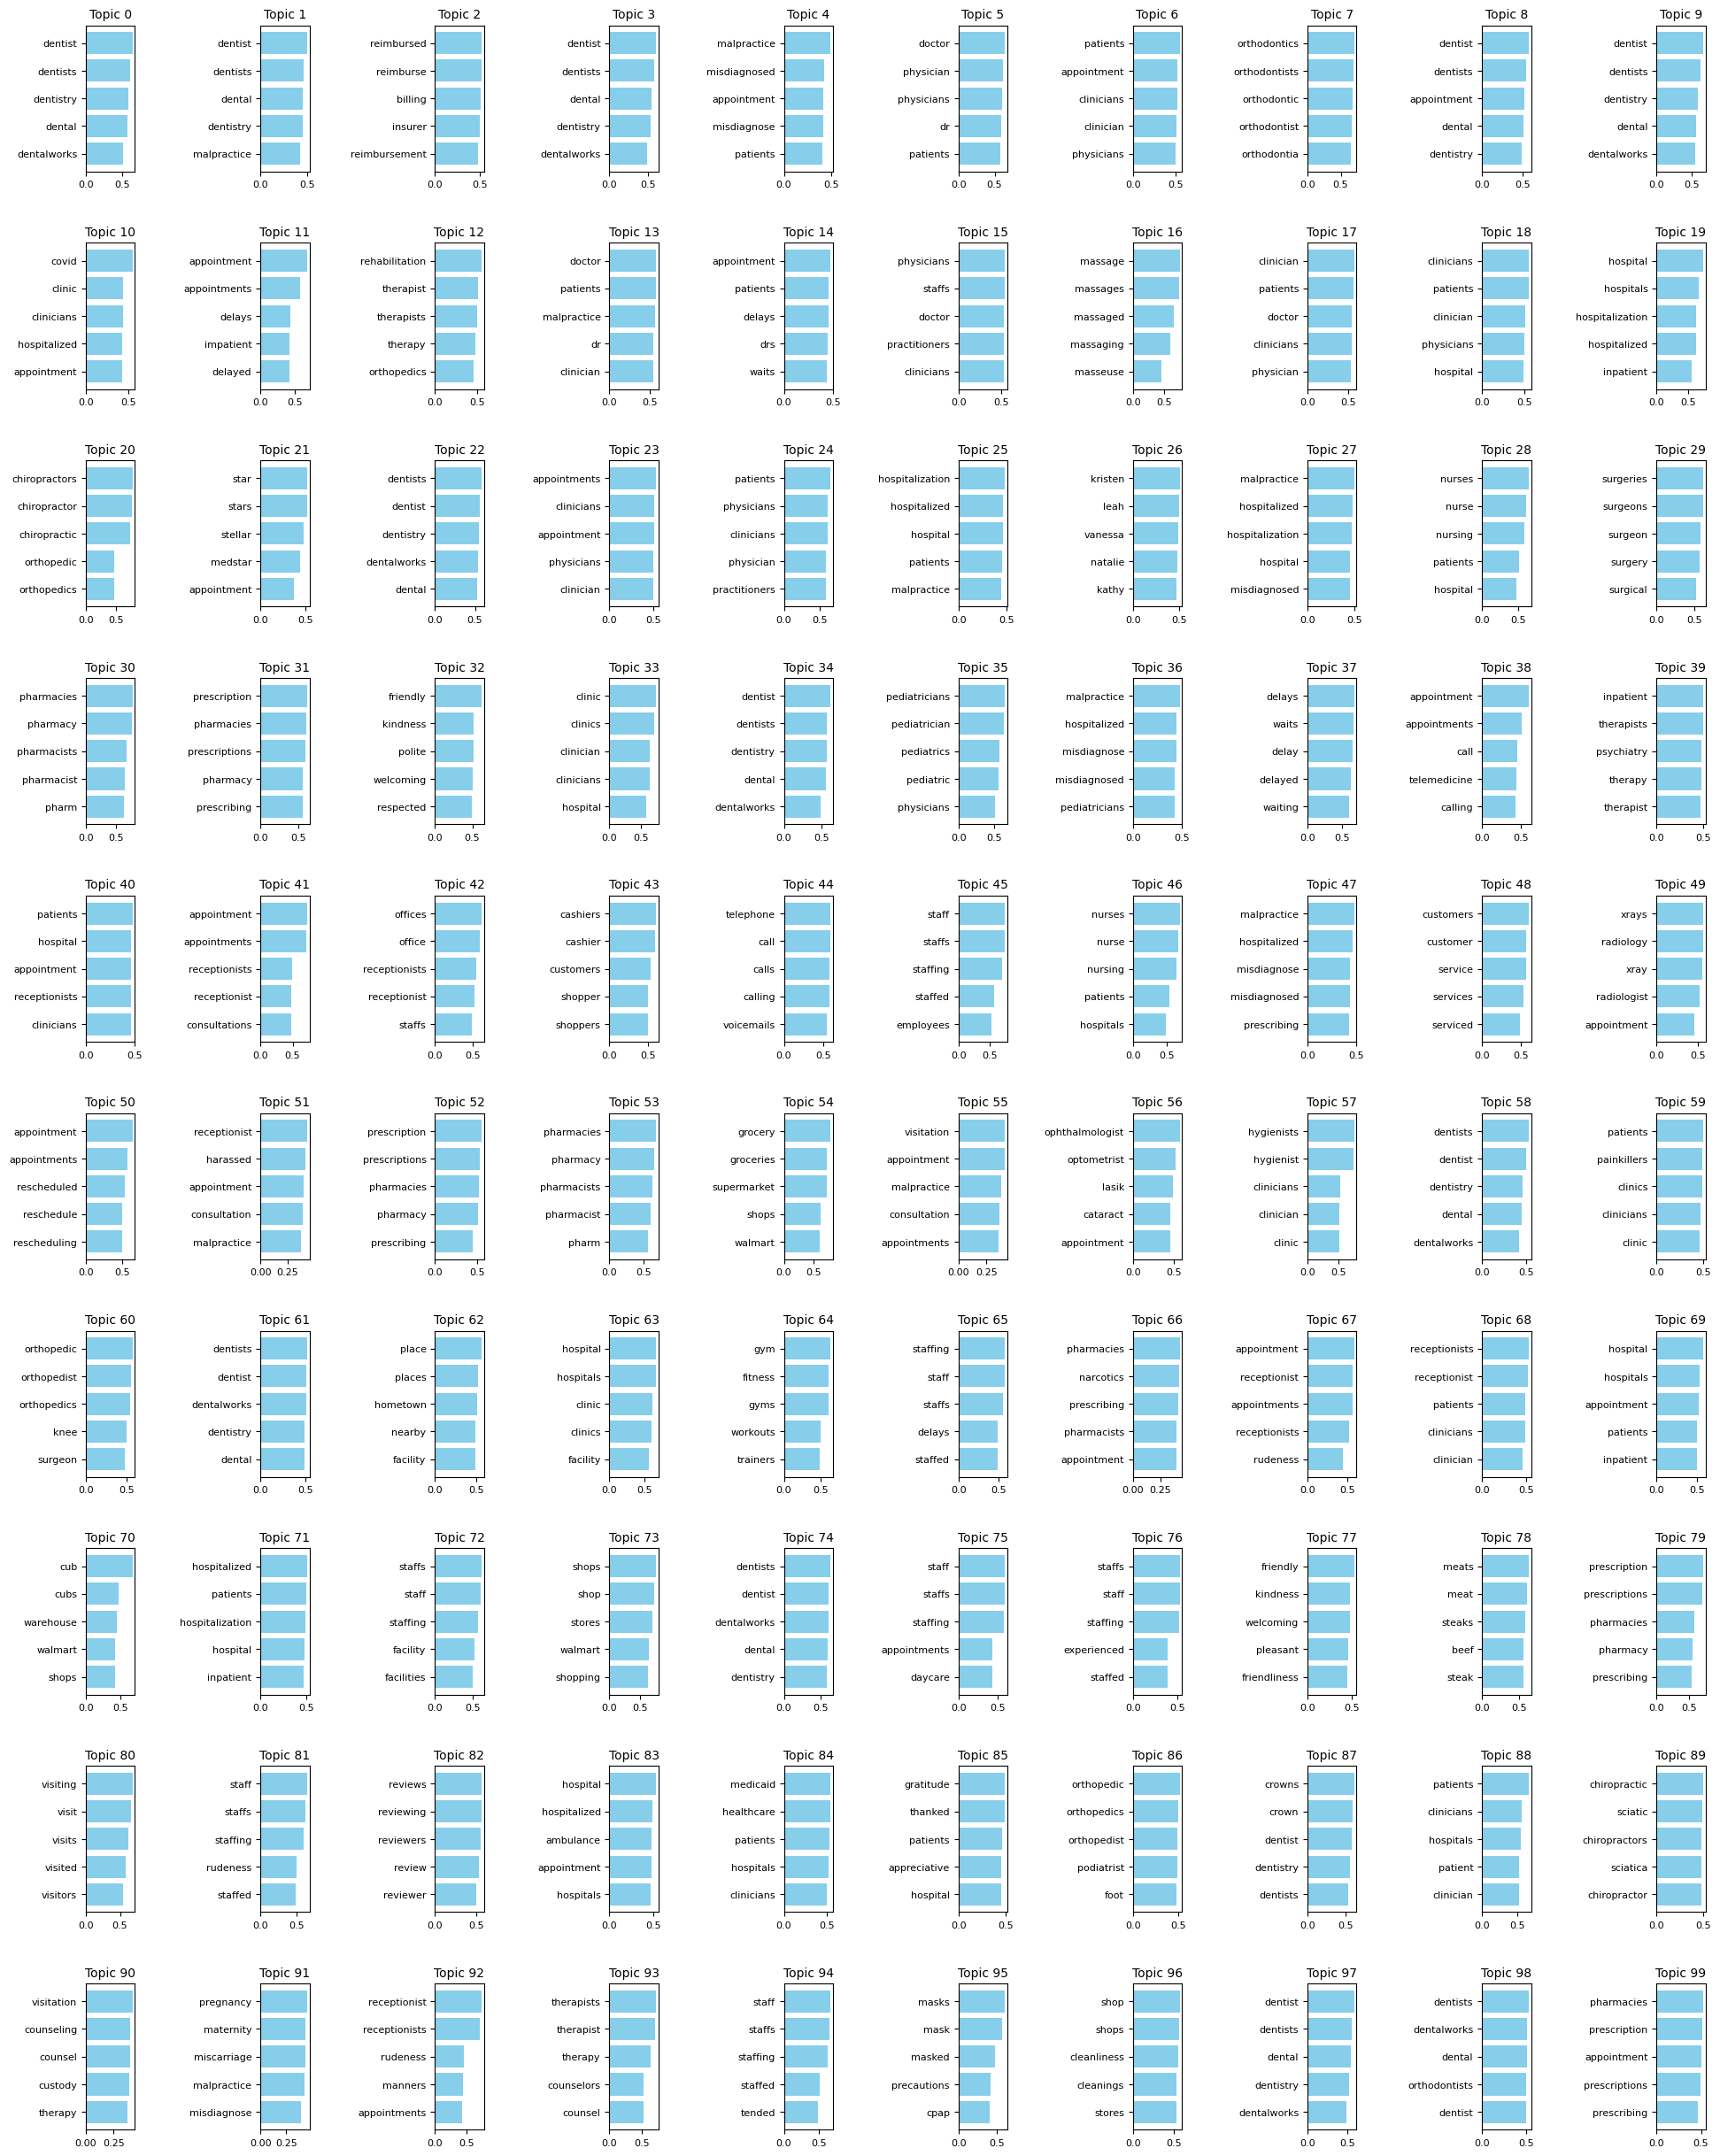

In [17]:
import matplotlib.pyplot as plt
import math

#get topic data
topics_words, word_scores, topic_nums = model.get_topics()

num_topics_to_display = 100 #can change
top_n_words = 5

#create grid plot
num_cols = 10
num_rows = math.ceil(num_topics_to_display / num_cols)

#create figure with a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize = (20, 2.5 * num_rows))
#flatten 2d array of axes
#for easy iteration
axes = axes.flatten()

for i in range(num_topics_to_display):
    if i>=len(topic_nums):
        axes[i].axis('off')
        continue
    
    #get data for current topic
    topic_id = topic_nums[i]
    words = topic_words[i][:top_n_words]
    scores = word_scores[i][:top_n_words]
    
    #select the current subplot
    ax = axes[i]
    
    #plot the horizontal bar chart
    ax.barh(range(len(words)), scores[::-1], color='skyblue') # Invert scores for correct order
    ax.set_yticks(range(len(words)))
    ax.set_yticklabels(words[::-1], fontsize=8) # Invert words to match scores
    
    ax.set_title(f"Topic {topic_id}", fontsize=10)
    ax.tick_params(axis='x', labelsize=8)

# Hide any unused subplots at the end
for j in range(num_topics_to_display, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap and save the figure
plt.tight_layout(pad=3.0)
plt.savefig("top2vec_topic_barcharts.png", dpi=300)
plt.show()


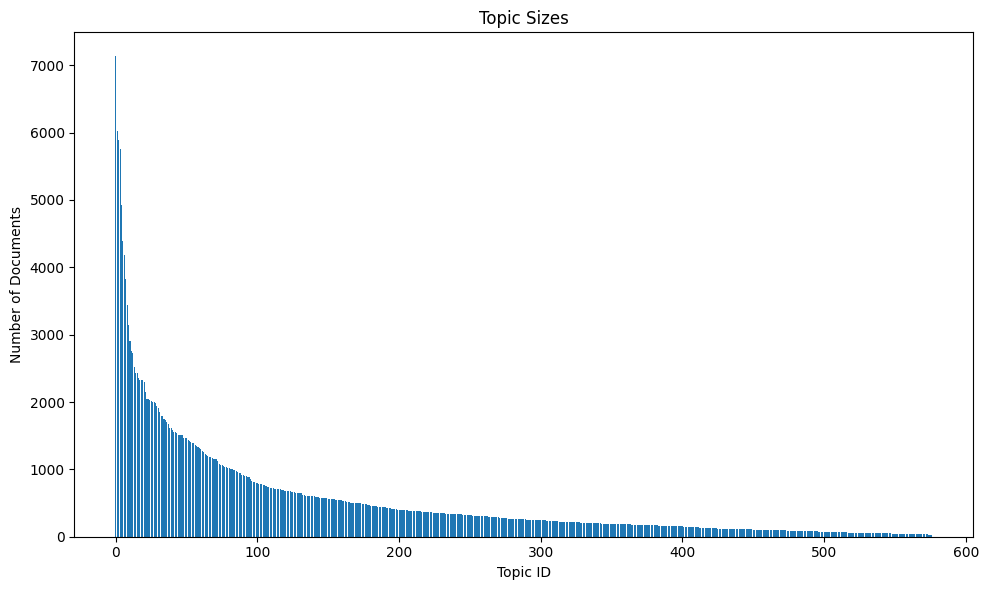

In [18]:
import matplotlib.pyplot as plt

# Sort by topic ID
df_topics_sorted = df_topics.sort_values("Topic ID")

plt.figure(figsize=(10, 6))
plt.bar(df_topics_sorted["Topic ID"], df_topics_sorted["Doc Count"])
plt.xlabel("Topic ID")
plt.ylabel("Number of Documents")
plt.title("Topic Sizes")
plt.tight_layout()
plt.show()


**WORD CLOUD PER TOPIC**

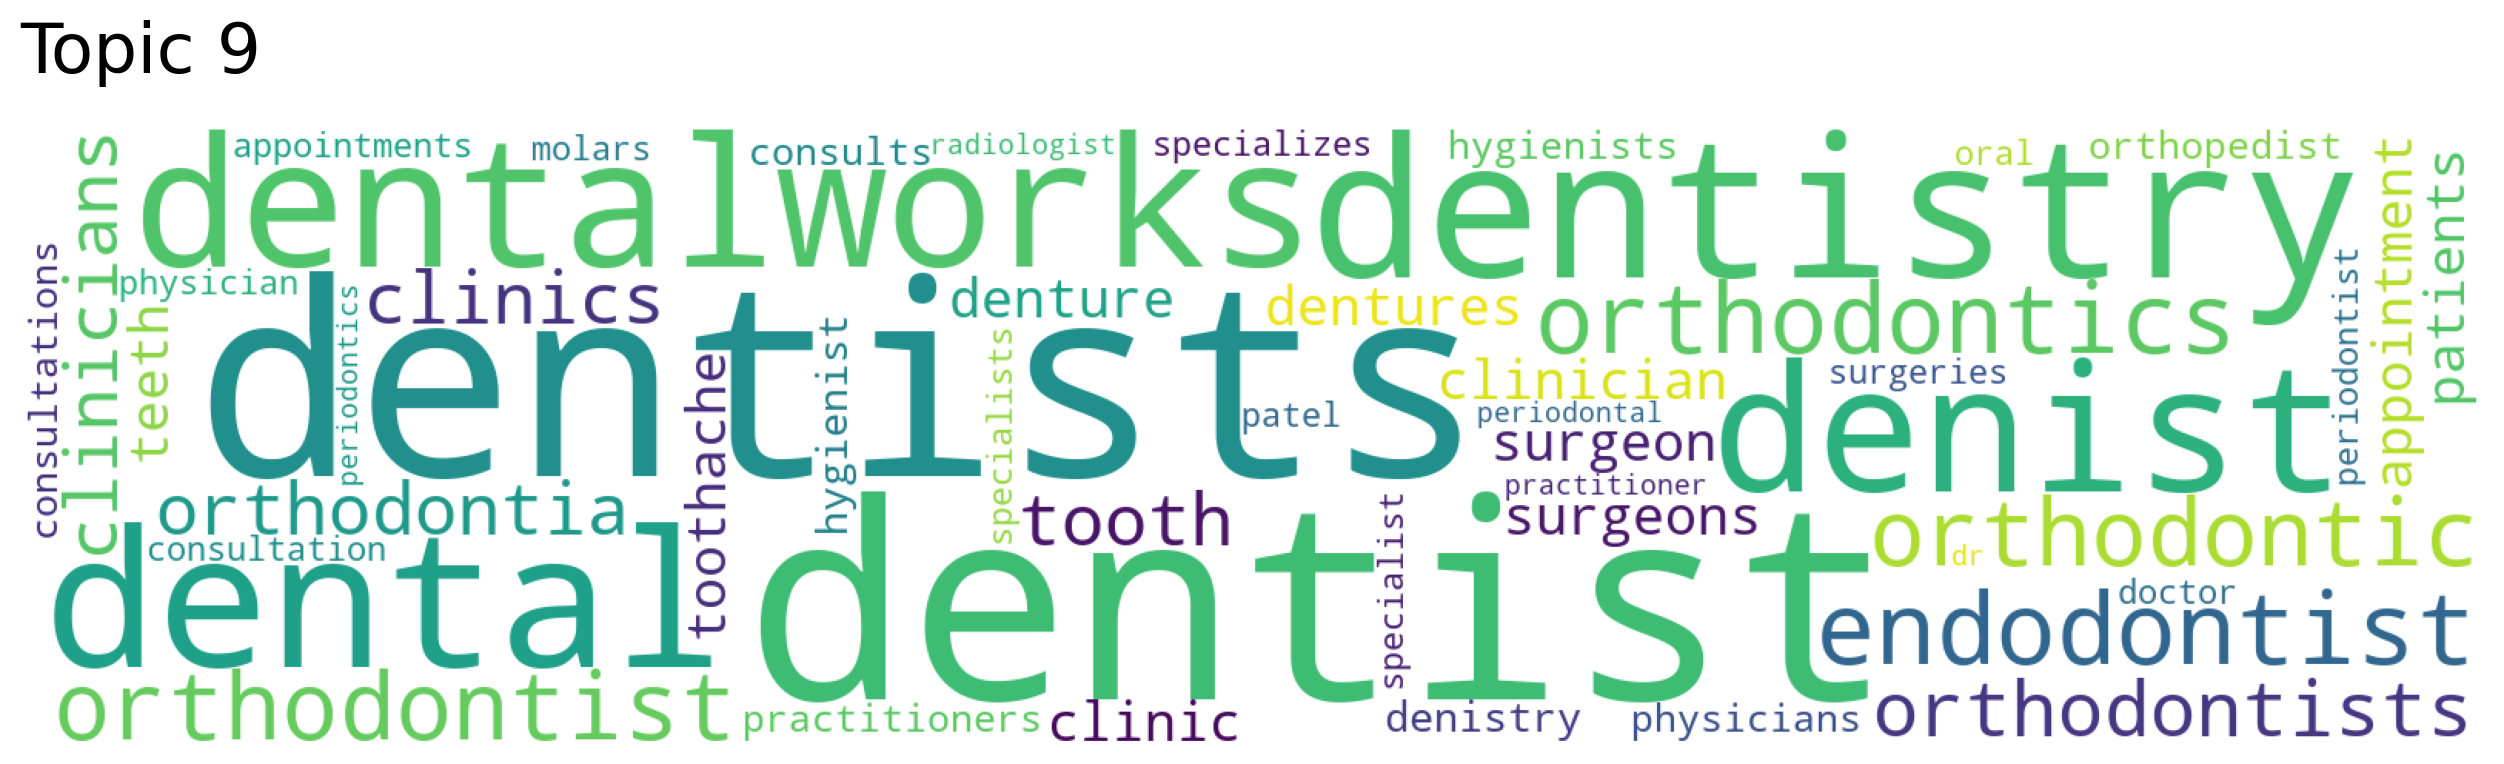

In [19]:
topic_words, word_scores, topic_nums = model.get_topics()
topic_sizes, _ = model.get_topic_sizes()
topic_to_visualize = topic_nums[9]
model.generate_topic_wordcloud(topic_to_visualize, background_color='white')

**INTERTOPIC DISTANCE MAP**

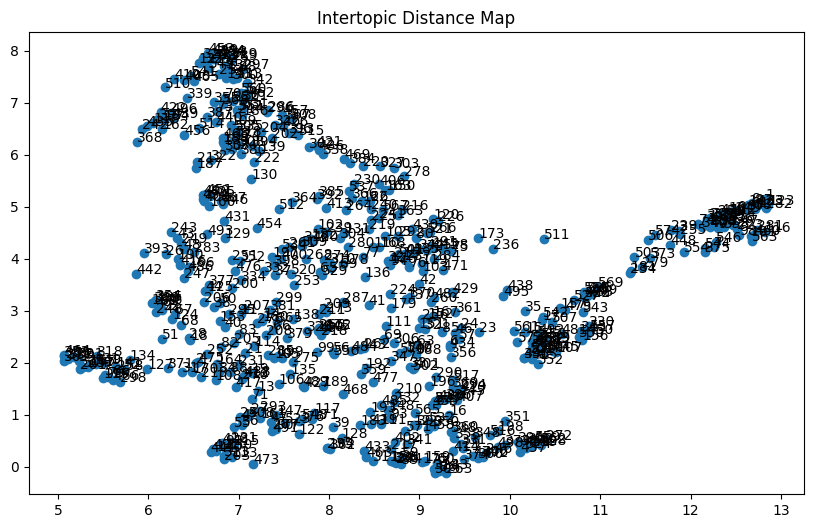

In [20]:
from umap import UMAP
import matplotlib.pyplot as plt

topic_vectors = model.topic_vectors
reduced = UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(topic_vectors)

plt.figure(figsize=(10, 6))
plt.scatter(reduced[:, 0], reduced[:, 1])
for i, (x, y) in enumerate(reduced):
    plt.text(x, y, str(i))
plt.title("Intertopic Distance Map")
plt.show()

**HIERARCHICAL CLUSTERING DENDOGRAM**

In [21]:


#get topic data
topic_vectors = model.topic_vectors
topic_nums = model.get_topics()[2]

#create dendogram
linkage_function = lambda x: linkage(x, method='ward', metric='euclidean')

#pass the raw topic_vectors, not precomputed linkage matrix
fig = ff.create_dendrogram(
    topic_vectors,
    orientation='left',
    labels=[f"Topic {num}" for num in topic_nums],
    linkagefun=linkage_function  
)

#layout setting
fig.update_layout(
    width=800,
    height=8000,  # Increase height to provide more space for labels
    title="Hierarchical Clustering of Topics (Vertical)",
    xaxis_title="Distance",
    yaxis_title="Topics"
)

# Show the interactive plot
fig.show()


## **SAVE**

In [22]:
model.save("top2vec_neg2.pkl")
model.save("top2vec_neg2")
#document embedding
np.save("top2vec_doc_embeddings.npy", model.document_vectors)
#topic vector
np.save("top2vec_topic_vectors.npy", model.topic_vectors)